In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# Reflect an existing database into a new model
Base = automap_base()
# Reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database
# Perform a query to retrieve the data and precipitation scores
Results = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= dt.date(2016, 8, 23)).all()

In [13]:
# Save the query results as a Pandas DataFrame and set the index to the date column
# Sort the dataframe by date
prec_df = pd.DataFrame(Results, columns=['Year', 'Precipitation'])

In [14]:
prec_df.set_index(prec_df['Year'], inplace=True)
prec_sort = prec_df.sort_index()
prec_sort

,Year,Precipitation
Year,,
2016-08-23,2016-08-23,0.00
2016-08-23,2016-08-23,NaN
2016-08-23,2016-08-23,1.79
2016-08-23,2016-08-23,0.05
2016-08-23,2016-08-23,0.15
...,...,...
2017-08-22,2017-08-22,0.00
2017-08-23,2017-08-23,0.00
2017-08-23,2017-08-23,0.00


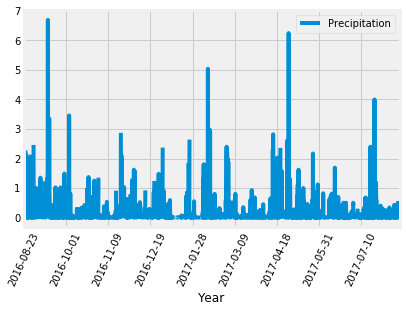

In [15]:
# Use Pandas Plotting with Matplotlib to plot the data
prec_sort.plot(rot=65)

In [16]:
# Use Pandas to calculate the summary statistics for the precipitation data
prec_sort.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [17]:
# Design a query to show how many stations are available in this dataset?
Results1 = session.query(Station.id).count()
print("There are {} stations in the dataset.".format(Results1))

There are 9 stations in the dataset.


In [18]:
# List the stations and the counts in descending order.
Results2 = session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
Results2

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [19]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
Results3 = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).all()
Results3

[(53.0, 87.0, 73.09795396419437)]

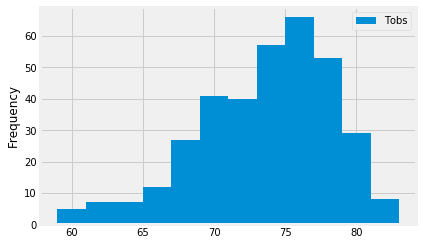

In [21]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
Results4 = session.query(Measurement.tobs).filter(Measurement.station == 'USC00519281').filter(Measurement.date >= dt.date(2016, 8, 23)).all()
temp_df = pd.DataFrame(Results4, columns=['Tobs'])
temp_df.plot.hist(bins=12)

In [22]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [28]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
low, avg, high = calc_temps('2016-06-02', '2016-06-28')[0]

//anaconda3/envs/PythonData/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  


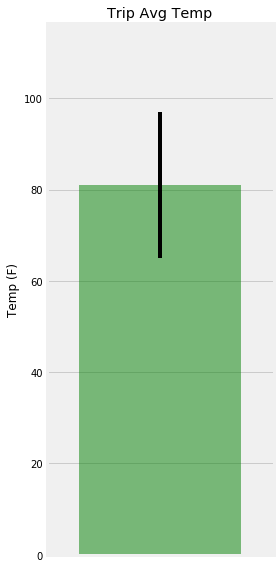

In [41]:
# Plot the results from your previous query as a bar chart. 
fig, ax = plt.subplots(figsize=plt.figaspect(2.))
xpos = 1
yerr = high-low

bar = ax.bar(xpos, high, yerr=yerr, alpha=0.5, color='green', align="center")
ax.set(xticks=range(xpos), xticklabels="a", title="Trip Avg Temp", ylabel="Temp (F)")
ax.margins(.2, .2)
fig.tight_layout()
fig.show()

In [45]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
prev_year_start = dt.date(2016, 6, 2) - dt.timedelta(days=365)
prev_year_end = dt.date(2016, 6, 28) - dt.timedelta(days=365)
sel = [Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation, func.sum(Measurement.prcp)]
Results5 = session.query(*sel).filter(Measurement.station==Station.station).filter(Measurement.date >= prev_year_start).filter(Measurement.date <= prev_year_end).group_by(Station.name).order_by(func.sum(Measurement.prcp).desc()).all()
Results5

[('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  10.95),
 ('USC00519281',
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9,
  3.9099999999999997),
 ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 1.8),
 ('USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0,
  1.11),
 ('USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5,
  0.52),
 ('USC00511918',
  'HONOLULU OBSERVATORY 702.2, HI US',
  21.3152,
  -157.9992,
  0.9,
  0.22000000000000003),
 ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 0.18),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.17)]